In [1]:
import sys
import typing as t
import textwrap
from pathlib import Path
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END

sys.path.append(str(Path().cwd().parent))

from llm_experiments.models import instantiate_chat

In [2]:
class State(t.TypedDict):
    purpose: str
    code: str
    review: str
    approved: t.Literal["true", "false"]

In [3]:
class Code(BaseModel):
    code: str = Field(description="the code to be written")

In [4]:
class Review(BaseModel):
    approved: t.Literal["true", "false"] = Field(description="true if the code is approved, false otherwise")
    review: str = Field(description="feedback on the code")

In [5]:
model = instantiate_chat("4o-mini")
coder = model.with_structured_output(Code)
reviewer = model.with_structured_output(Review)

In [6]:
def write_code(state: State):
    for k, v in state.items():
        print(f" {k} ".center(88, "="))
        print(v)
        print()

    role = textwrap.dedent(
        f"""
        You are a senior software engineer writing code.
        The purpose of the code is to {state["purpose"]}.
        {f"but take into account the following review: {state['review']}" if state.get("approved") else ""}
        """
    )
    messages = [
        {"role": "system", "content": role},
    ]
    res = coder.invoke(messages)
    return {"code": res.code}

In [7]:
def review_code(state: State):
    role = textwrap.dedent(
        f"""
        You are a senior software engineer reviewing a piece of code.
        The purpose of the code is to {state["purpose"]}.
        if the code is not good enough, return "false" in the approved field. otherwise, return "true".
        """
    )
    messages = [
        {"role": "system", "content": role},
        {"role": "user", "content": state["code"]},
    ]
    res = reviewer.invoke(messages)
    return {"approved": res.approved, "review": res.review}

In [8]:
def router(state: State):
    match state["approved"]:
        case "true":
            return "approved"
        case "false":
            return "needs_improvement"
        case _:
            raise ValueError(f"Invalid approval status: {state['approved']}")

In [9]:
builder = StateGraph(State)

builder.add_node("write_code", write_code)
builder.add_node("review_code", review_code)

builder.add_edge(START, "write_code")
builder.add_edge("write_code", "review_code")
builder.add_conditional_edges("review_code", router, {"approved": END, "needs_improvement": "write_code"})

graph = builder.compile()

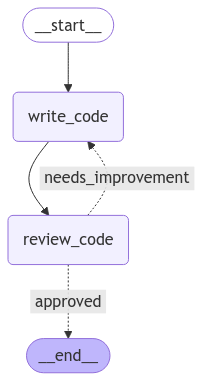

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
res = graph.invoke({"purpose": "save all pages of a kindle book to a pdf file"})

======================================= purpose ========================================
save all pages of a kindle book to a pdf file

======================================= purpose ========================================
save all pages of a kindle book to a pdf file

========================================= code =========================================
import os
import boto3
from fpdf import FPDF

# Initialize S3 Client
def init_s3_client():
    return boto3.client('s3')

# Download Kindle book pages (this is a placeholder, as specific APIs will vary)
def download_kindle_book_pages(book_id, output_dir):
    # Placeholder for downloading pages from Kindle
    # In an actual implementation, you would have to interact with Kindle API or extract them from your device
    # For demonstration purposes, let’s assume we create some dummy text files
    for i in range(1, 21):  # Assuming the book has 20 pages
        with open(os.path.join(output_dir, f'page_{i}.txt'), 'w') as f:
        

In [16]:
print(res["code"])

import os
import tempfile
import logging
from fpdf import FPDF

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class PDFGenerator:
    def __init__(self, title, font='Arial', font_size=12, margin=10):
        self.pdf = FPDF()
        self.title = title
        self.font = font
        self.font_size = font_size
        self.margin = margin
        self.setup_pdf()

    def setup_pdf(self):
        self.pdf.add_page()
        self.pdf.set_font(self.font, size=self.font_size)

    def add_page_content(self, content):
        if content:
            self.pdf.multi_cell(0, 10, content)
            self.pdf.add_page()  # Add a new page only if we have content

    def save_pdf(self, filename):
        try:
            self.pdf.output(filename)
            logging.info(f'PDF saved as {filename}')
        except Exception as e:
            logging.error(f'Error saving PDF: {e}')

def download_kindle_book_pages(book_id):
    pa